In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from functools import reduce
import wandb
import pandas as pd
from matplotlib import pyplot as plt
import opf
import opf.dataset
import utils
import logging
import seaborn as sns

logging.getLogger("pytorch_lightning").setLevel(logging.WARN)

save_dir = "/home/damow/Dropbox/Apps/Overleaf/Unsupervised Optimal Power Flow Using Graph Neural Networks/"
figure_dir = save_dir + "figures/"
table_dir = save_dir + "tables/"
log_dir = "../logs/"

In [3]:
api = wandb.Api()
runs = api.runs("damowerko/opf", filters={"tags": "sweep1"})
data = [{**run.config, **run.summary} for run in runs]
df = pd.DataFrame(data)

In [6]:
parameters = ["s", "t", "K", "F", "L", "lr"]
best_idx = df[df["test/inequality/rate"] < 0.01]["test/cost"].idxmin()
best_parameters = {name: df.iloc[best_idx][name] for name in parameters}
display(best_parameters)

{'s': 10, 't': 500, 'K': 8, 'F': 32, 'L': 2, 'lr': 0.0001}

In [11]:
# indices and column values to be renamed
rename_dict = {
    "lr": "$\eta$",
    0.00001: "1e-5",
    0.0001: "1e-4",
    0.001: "1e-3",
    "test/cost": "Generation Cost",
    "test/inequality/rate": "Constraint Violation Rate",
}
rename = lambda param: rename_dict[param] if param in rename_dict else param
renamed_params = {rename(k): rename(v) for k, v in best_parameters.items()}

values = ["test/cost", "test/inequality/rate"]
for params in [("K", "F"), ("s", "t"), ("L", "lr")]:
    filename = f"{table_dir}search_{params[0]}{params[1]}.tex"
    selected = []
    for param_name, param_value in best_parameters.items():
        if param_name in (params[0], params[1]):
            continue
        selected.append(df[param_name] == param_value)
    selected = reduce(lambda a, b: a & b, selected)
    table = df[selected].pivot(params[0], params[1], values)

    # Rename the indices and index names based on rename_dict
    table = table.rename(columns=rename_dict, index=rename_dict)
    params = list(map(rename, params))
    table.index.name = params[0]
    table.columns.names = [None, params[1]]

    style = table.style.format("{:0.4f}").applymap(
        lambda x: "font-weight:bold;",
        subset=(renamed_params[params[0]], (slice(None), renamed_params[params[1]])),
    )
    display(style)
    style.to_latex(buf=filename, convert_css=True, hrules=True)


In [29]:
ids = ["2lllzf30", "2ng1ftuc", "2zdzkf7r", "3ttyfoc7"]
runs = [api.run(f"damowerko/opf/{id}") for id in ids]
data = []
dm = opf.dataset.CaseDataModule("case30", "../data", adj_threshold=0.01)
for run in runs:
    barrier = opf.utils.create_model(dm, run.config)
    utils.load_checkpoint(barrier, run.id, log_dir)
    data.append(utils.test(barrier, dm))

/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1295: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 100%|██████████| 798/798 [00:15<00:00, 53.07it/s]


/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(


Testing: 100%|██████████| 798/798 [00:14<00:00, 54.53it/s]


/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


Testing: 100%|██████████| 798/798 [00:14<00:00, 54.29it/s]


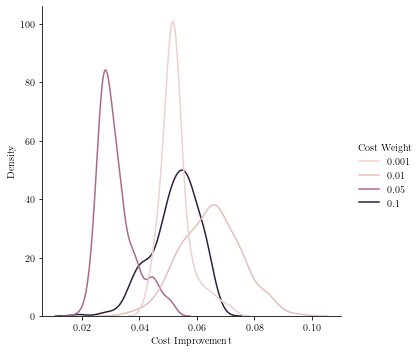

In [123]:
for i in range(len(ids)):
    config = runs[i].config
    data[i][list(config.keys())] = list(config.values())
    data[i]["Cost Improvement"] = data[i]["acopf/cost"] - data[i]["test/cost"]
    data[i]["id"] = ids[i]
df = (pd
    .concat(data, ignore_index=True)
    .rename(columns = {"cost_weight": "Cost Weight"})
)
df = df.loc[df["test/inequality/error_max"] < 0.01]

sns.displot(df, x="Cost Improvement", hue="Cost Weight", kind="kde", common_norm=False)